In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yfinance_loader import download_tickers
import timeit

%matplotlib inline

In [2]:
tickers = pd.read_csv('ticker_lists/ndx.csv', header=None)
tickers = tickers[0].to_list()

In [66]:
# Timing 
i = 1
setup_code = 'from yfinance_loader import download_tickers'
run = """download_tickers(['XACTC25.CO'], False, return_only=['Adj Close','Volume'])"""
timeit.timeit(run, setup=setup_code, number=i)/i

[*********************100%***********************]  1 of 1 completed


0.31569908699975713

In [5]:
#tickers = ['SPY']
stocks = download_tickers(tickers, False, return_only=['Adj Close'])

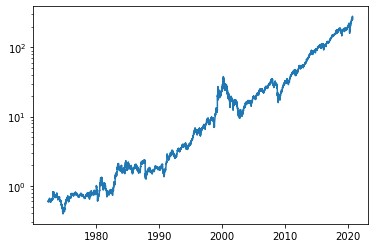

In [6]:
plt.plot(stocks.mean(axis=1).iloc[0:-1])
plt.yscale('log')